In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tqdm
import random

from experiments.npe.model import get_npe_model
from experiments.npe.simulate import show_simulation
from renderer.threecircles import ThreeCircles
from experiments.playconf.environment import Environment, initialize_scene_from_configuration, make_training
from experiments.playconf.rl import get_actor, get_experience, get_critic, get_joint, get_random_experience, get_naive_adversarial_loss

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
Loading chipmunk for Linux (64bit) [/home/shreyask/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/pymunk/libchipmunk.so]


In [38]:
with open('data/threecircles_munk_million_complexities.p', 'rb') as f:
    data = pickle.load(f)

train_x, train_y, _ = data['train']
val_x, val_y = data['val']

train_x = np.array(train_x)
train_y = np.array(train_y)

val_x = np.array(val_x)
val_y = np.array(val_y)

def breakdown(X):
    return [
        np.array([x[0] for x in X]),
        np.array([x[1] for x in X]),
        np.array([x[2] for x in X]),
        np.array([x[3] for x in X]),
        np.array([x[4] for x in X]),
    ]

In [21]:
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    return ax

def plot_dataset(x, y):
    px = []
    py = []

    for t in range(len(x)):
        points_p = np.array([x[t][i][:2] for i in range(3)])
        points_n = np.array([x[t][i][2:] for i in range(3)])

        px.append(points_p[0][0])
        py.append(points_p[0][1])

    density_scatter(np.array(px), np.array(py), bins=10)

In [41]:
sample_indexes = np.random.choice(len(train_x), 100000)

model_baseline = get_npe_model(max_pairs = 2)
model_baseline.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0003))

history_baseline = model_baseline.fit(
    breakdown(train_x[sample_indexes]),
    train_y[sample_indexes],
    validation_data=(breakdown(val_x), val_y),
    epochs=100,
    batch_size=50,
)

Train on 100000 samples, validate on 10000 samples
Epoch 1/100
100000/100000 [==============================] - 23s 233us/sample - loss: 0.0657 - val_loss: 0.0454
Epoch 2/100
100000/100000 [==============================] - 21s 215us/sample - loss: 0.0401 - val_loss: 0.0368
Epoch 3/100
100000/100000 [==============================] - 22s 216us/sample - loss: 0.0328 - val_loss: 0.0301
Epoch 4/100
100000/100000 [==============================] - 22s 217us/sample - loss: 0.0299 - val_loss: 0.0374
Epoch 5/100
100000/100000 [==============================] - 22s 217us/sample - loss: 0.0281 - val_loss: 0.0253
Epoch 6/100
100000/100000 [==============================] - 21s 214us/sample - loss: 0.0267 - val_loss: 0.0240
Epoch 7/100
100000/100000 [==============================] - 21s 210us/sample - loss: 0.0256 - val_loss: 0.0234
Epoch 8/100
100000/100000 [==============================] - 21s 210us/sample - loss: 0.0247 - val_loss: 0.0229
Epoch 9/100
100000/100000 [==========================

KeyboardInterrupt: 

In [47]:
from experiments.npe.simulate import show_simulation
show_simulation(model_baseline)

KeyboardInterrupt: 

In [155]:
sample_size = 10000
reservoir_size = 100000
batch_size = 32

model = get_npe_model(max_pairs = 2)
model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0003))

model_baseline = get_npe_model(max_pairs = 2)
model_baseline.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0003))

model_baseline.set_weights(model.get_weights()) 

critic = get_npe_model(max_pairs = 2, predict_sigmoid = True)
critic.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam())

last_loss = None
batch_number_pg = []

def on_batch_end(batch_number, logs):
    global last_loss

    if not last_loss:
        last_loss = logs['loss']
        return
    
    batch_number_pg.append((
        batch_number,
        logs['loss'] - last_loss
    ))
    
    last_loss = logs['loss']
    
def get_critic_training_data(x, batch_number_pg):
    rx = []
    ry = []
    
    for batch_number, pg in batch_number_pg:
        batch = x[batch_number*batch_size:batch_number*batch_size + batch_size]
        
        for b in batch:
            rx.append(b)
            ry.append(pg)
            
    return np.array(rx), np.array(ry)
    

batch_end_callback = tf.keras.callbacks.LambdaCallback(on_batch_end=on_batch_end)

# Sample a few
sample_indexes = np.random.choice(len(train_x), sample_size)

last_loss = None
batch_number_pg = []

model.fit(
    breakdown(train_x[sample_indexes]),
    train_y[sample_indexes],
    validation_data=(breakdown(val_x), val_y),
    epochs=1,
    batch_size=batch_size,
    shuffle=False,
    callbacks=[batch_end_callback]
)

model_baseline.fit(
    breakdown(train_x[sample_indexes]),
    train_y[sample_indexes],
    validation_data=(breakdown(val_x), val_y),
    epochs=1,
    batch_size=batch_size,
    shuffle=False,
)

batch_src = train_x[sample_indexes]

iterations = 100

exp_losses = []
baseline_losses = []

for i in range(iterations):
    rx, ry = get_critic_training_data(batch_src, batch_number_pg)
    m = ry.mean()
    ry[ry > m] = 1.0
    ry[ry <= m] = 0.0
    
    critic = get_npe_model(max_pairs = 2, predict_sigmoid = True)
    critic.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam())
    
    critic.fit(
        breakdown(rx),
        ry,
        epochs=10,
        batch_size=32,
        validation_split=0.2,
        shuffle=True,
        verbose=0,
    )
    
    sample_indexes = np.random.choice(len(train_x), reservoir_size)
    quality = np.squeeze(critic.predict(breakdown(train_x[sample_indexes])))
    
    selected = sample_indexes[quality.argsort()[::-1][:sample_size]]
    
    last_loss = None
    batch_number_pg = []
    
    history = model.fit(
        breakdown(train_x[selected]),
        train_y[selected],
        validation_data=(breakdown(val_x), val_y),
        epochs=1,
        batch_size=batch_size,
        shuffle=True,
        callbacks=[batch_end_callback],
        verbose=0,
    )
    
    batch_src = train_x[selected]

    history_baseline = model_baseline.fit(
        breakdown(train_x[sample_indexes[:sample_size]]),
        train_y[sample_indexes[:sample_size]],
        validation_data=(breakdown(val_x), val_y),
        epochs=1,
        batch_size=batch_size,
        shuffle=True,
        verbose=0,
    )
    
    exp_losses.append((history.history['loss'][-1], history.history['val_loss'][-1]))
    baseline_losses.append((history_baseline.history['loss'][-1], history_baseline.history['val_loss'][-1]))
    
    print("%i, Exp: %s, Baseline: %s" % (i, exp_losses[-1], baseline_losses[-1]))

Train on 10000 samples, validate on 10000 samples
10000/10000 [==============================] - 7s 679us/sample - loss: 0.1137 - val_loss: 0.0998
Train on 10000 samples, validate on 10000 samples
10000/10000 [==============================] - 7s 670us/sample - loss: 0.1137 - val_loss: 0.0998
0, Exp: (0.07652768524885177, 0.08394900672882795), Baseline: (0.09014860411286355, 0.08543440182209015)
1, Exp: (0.09373645427823067, 0.11854407916665077), Baseline: (0.07394424200057984, 0.07082625719308853)
2, Exp: (0.08382267119884491, 0.06829371928274632), Baseline: (0.058539870384335516, 0.06489530899524688)
3, Exp: (0.07219090329408645, 0.06952764573395252), Baseline: (0.053618705102801326, 0.051889255566895005)
4, Exp: (0.056610083717107774, 0.07255957516729832), Baseline: (0.053485907888412475, 0.043767893163859845)
5, Exp: (0.07467738796472549, 0.07894309100210667), Baseline: (0.050195164185762406, 0.05013826647102833)
6, Exp: (0.05685906952917576, 0.11163267294168472), Baseline: (0.0493

74, Exp: (0.03507646557688713, 0.035532308061420916), Baseline: (0.024618391758203507, 0.026387437182664873)
75, Exp: (0.02941240501999855, 0.03049194170832634), Baseline: (0.024106739984452723, 0.03040350187420845)
76, Exp: (0.022793871746212245, 0.05152941997349262), Baseline: (0.02492376374080777, 0.02275387237370014)
77, Exp: (0.02993207429423928, 0.06503523955345154), Baseline: (0.025139099530130625, 0.026866907310672105)
78, Exp: (0.030845123459398747, 0.04995736408606172), Baseline: (0.023608800711482764, 0.027782404746860265)
79, Exp: (0.02414351529106498, 0.0578268661364913), Baseline: (0.023720072329044342, 0.021074134300649167)
80, Exp: (0.03071824884414673, 0.031096442881226538), Baseline: (0.024655430645495652, 0.02842095340490341)
81, Exp: (0.02491093385666609, 0.02955551612973213), Baseline: (0.023937039468437435, 0.02146400396861136)
82, Exp: (0.027553351882100105, 0.035230826844275), Baseline: (0.02257924861982465, 0.028427105462551117)
83, Exp: (0.026086006189882754, 

In [142]:
rx, ry = get_critic_training_data(train_x[sample_indexes], batch_number_pg)

In [143]:
m = ry.mean()
ry[ry > m] = 1.0
ry[ry <= m] = 0.0

In [144]:
critic = get_npe_model(max_pairs = 2, predict_sigmoid = True)
critic.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam())

critic_history = critic.fit(
    breakdown(rx),
    ry,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    shuffle=True
)

Train on 7999 samples, validate on 2000 samples
Epoch 1/10
7999/7999 [==============================] - 7s 888us/sample - loss: 0.6934 - val_loss: 0.6924
Epoch 2/10
7999/7999 [==============================] - 3s 342us/sample - loss: 0.6932 - val_loss: 0.6913
Epoch 3/10
7999/7999 [==============================] - 3s 340us/sample - loss: 0.6931 - val_loss: 0.6925
Epoch 4/10
7999/7999 [==============================] - 3s 354us/sample - loss: 0.6931 - val_loss: 0.6908
Epoch 5/10
7999/7999 [==============================] - 3s 343us/sample - loss: 0.6931 - val_loss: 0.6915
Epoch 6/10
7999/7999 [==============================] - 3s 345us/sample - loss: 0.6927 - val_loss: 0.6911
Epoch 7/10
7999/7999 [==============================] - 3s 344us/sample - loss: 0.6925 - val_loss: 0.6896
Epoch 8/10
7999/7999 [==============================] - 3s 343us/sample - loss: 0.6919 - val_loss: 0.6882
Epoch 9/10
7999/7999 [==============================] - 3s 341us/sample - loss: 0.6911 - val_loss: 0.687

In [131]:
p = critic.predict(breakdown(train_x[:100000]))

In [132]:
p.argmax(), p.argmin()

(90977, 58407)

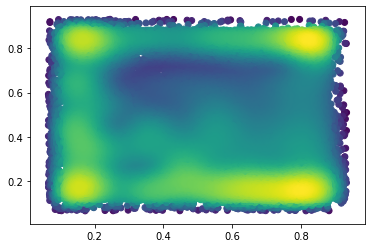

In [138]:
plot_dataset(train_x[:100000][np.squeeze(p > np.quantile(p, 0.8))], train_y[:100000][np.squeeze(p > np.quantile(p, 0.8))])

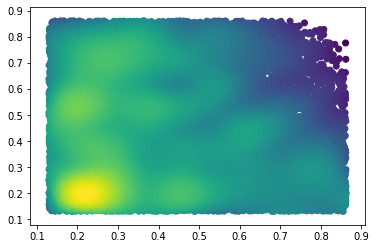

In [139]:
plot_dataset(train_x[:100000][np.squeeze(p < np.quantile(p, 0.2))], train_y[:100000][np.squeeze(p < np.quantile(p, 0.2))])

In [141]:
plt.plot(critic_history.history['val_loss'])

NameError: name 'critic_history' is not defined

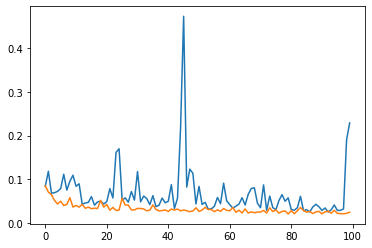

In [157]:
plt.plot([x[1] for x in exp_losses])
plt.plot([x[1] for x in baseline_losses])